In [1]:
%load_ext autoreload
%autoreload 2
from notebook_utils import *

import warnings
warnings.filterwarnings('ignore')

# PLOTTING
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    'font.size':16,
    "lines.linewidth":2.0,
    "savefig.dpi":500,
    'text.latex.preamble':r'\boldmath'
})
plt.rc('axes', grid=True)
cmap=plt.cm.viridis
savedir= '/data/rcp/boolean/figs/'
if not os.path.exists(savedir):
    os.mkdir(savedir)

gpu_index = get_most_free_gpu()


In [2]:
runs = []
logs = []
global_path = '/data/rcp/boolean/experiments'

paths = [
    #'first'
    #"scale"
    #'wide'
    #"max_points",
    #"big_inputs",
    #"xor",
    #"xor_filtered",
    #"enough_points"
    #"controller"
    #"noiseless",
    #"noiseless_highdim"
    #"boolean_package"
    #"highdim"
    #"grid_search"
    #"bnet"
    #"bnet_morepoints"
    #"bnet_traj"
    "max_vars"
    #"bnet_hard"
    #"large_max_ops"
       ]


NaN = np.nan
Infinity = np.nan

for path in paths:
    path = os.path.join(global_path, path)
    path = path.rstrip('/') + '/'
    print(path)

    dirnames = glob.glob(path+'*')
    dirnames = [p for p in dirnames if (os.path.isdir(p) and not p.endswith('__'))]
    print('{} runs found'.format(len(dirnames)))
    fails = 0
    for dirname in dirnames:
        if dirname.endswith('src'): continue
        if len(dirnames)<1000: print(dirname)
        #try : 
        latest, latest_pmlb, latest_osc = -1, -1, -1
        run = {}
        args = pickle.load(open(dirname+'/params.pkl', 'rb'))
        run['args'] = args
        run['logs'] = []
        run['pmlb'] = []
        run['oscillators'] = []
        run['num_params'] = []
        logfile = dirname+'/train.log'
        f = open(logfile, "r")
        for line in f.readlines():
            if '__log__' in line or '__pmlb__' in line or '__oscillators__' in line: 
                log = eval(line[line.find('{'):].rstrip('\n'))
                epoch = log['epoch']
                if epoch <= latest: run['logs'][-1] = log
                else:
                    latest = epoch
                    run['logs'].append(log)
        f.close()
        args.output_dir = Path(dirname)
        runs.append(run)
    print('{} fails'.format(fails))
    
params = defaultdict(list)
for run in runs:
    for k,v in vars(run['args']).items():
        params[k].append(v)
for k in params:
    try: params[k] = sorted(list(set(params[k])))
    except: pass

/data/rcp/boolean/experiments/max_vars/
2 runs found
/data/rcp/boolean/experiments/max_vars/exp_max_active_vars_10
/data/rcp/boolean/experiments/max_vars/exp_max_active_vars_20
0 fails


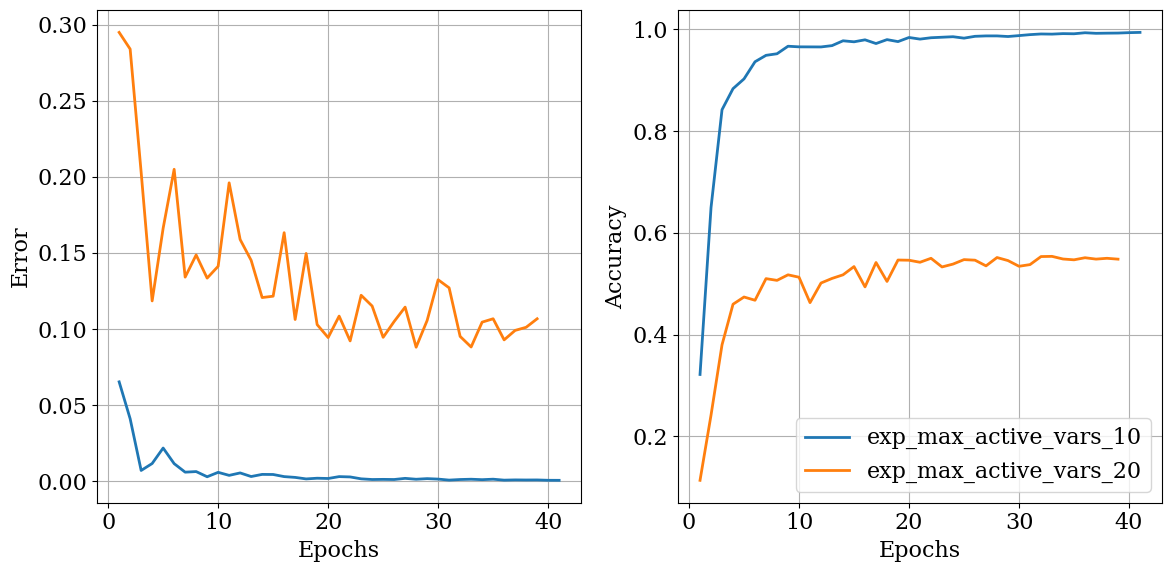

In [3]:
constraints = {
    #'simplify_form': ['shortest'],
}
selected_runs, selected_params = select_runs(runs, params, constraints)
latest = min([len(run['logs'])-1 for run in selected_runs])
#selected_runs = runs

fig, axarr = plt.subplots(1,2,figsize=(12,6))

for i, mode in enumerate(['logs']): 
    for run in selected_runs[:]:
        args = run['args']
        times = np.array(range(len(run[mode])))#[:latest]
        error    = [run[mode][t]['test_error']      for t in times]
        test_error    = [run[mode][t]['acc']      for t in times]
        label = args.exp_id
        #print(loss,correct,perfect,additional)
        axarr[0].plot(times+1, error, label=label)
        axarr[1].plot(times+1, test_error, label=label)

plt.legend()
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Error')
axarr[1].set_xlabel('Epochs')
axarr[1].set_ylabel('Accuracy')
#plt.xscale('log')

plt.tight_layout()
#plt.savefig(savedir+'simplification_loss_{}.pdf'.format('float' if args.float_sequences else 'int'))
plt.show()

/data/rcp/boolean/experiments/max_vars/exp_max_active_vars_10/evals.csv


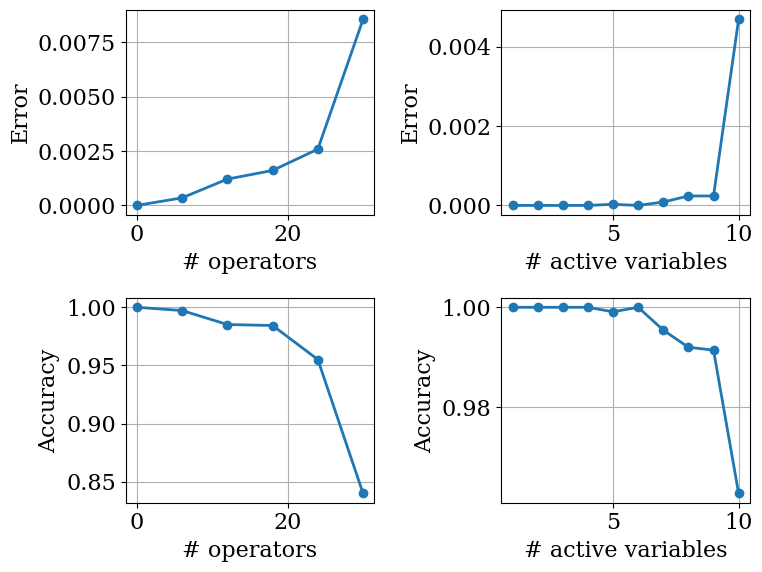

In [4]:
if selected_runs[0]['args'].max_flip_prob>0:    
    regime = 'noisy'
else:
    regime = 'noiseless'

if regime == 'noisy':
    ablations = {
            'info_n_active_vars':'# active variables', 
            #'info_n_ops':'# operators', 
            'info_n_inactive_vars':'# inactive variables',
            'info_n_points':'# input points', 
            'info_trajectory_flip_prob':'Exploration parameter',
            'info_flip_prob':'Flip probability',
            }
elif regime == 'noiseless':
    ablations = {'info_n_ops':'# operators', 
            'info_n_active_vars':'# active variables', 
            }
else:
    raise NotImplementedError
metrics = {'test_error':'Error', 'acc':'Accuracy'}

ablation2 = None#'info_n_active_vars' if regime=='noisy' else None
fig, axarr = plt.subplots(len(metrics), len(ablations), figsize=(4*len(ablations),3*len(metrics)))

for run in selected_runs[:1]:
    args = run['args']
    print(args.output_dir/'evals.csv')
    try: df = pd.read_csv(args.output_dir/'evals.csv')
    except: 
        print('fail'); continue

    #df = df.query("info_n_ops<40")
    #df = df.query("info_n_active_vars<=10")
    #n_points = df['info_n_points'].max()
    #df = df.query('info_n_points=={}'.format(n_points))
    #flip_prob = df['info_flip_prob'].min()
    #df = df.query('info_flip_prob=={}'.format(flip_prob))
    for info in ['info_n_inactive_vars','info_n_ops', 'info_trajejectory_flip_prob']:
        k=6
        try: 
            df[info] = pd.cut(df[info], bins=k, labels=np.linspace(df[info].min(), df[info].max(), k).astype(int))
        except: pass
    for i, (metric, metric_name) in enumerate(metrics.items()):
        for j, (ablation1, ablation_name) in enumerate(ablations.items()):
            if ablation2:
                for value in sorted(df[ablation2].unique()):
                    df2 = df[df[ablation2]==value]
                    x, y = df2.groupby(ablation1)[metric].mean().index, df2.groupby(ablation1)[metric].mean().values
                    yerr = 0#df2.groupby(ablation1)[metric].std().values
                    axarr[i,j].errorbar(x, y, yerr=yerr, marker='o', color=cmap(value/df[ablation2].max()))
            else:
                # errorbar plot
                x, y = df.groupby(ablation1)[metric].mean().index, df.groupby(ablation1)[metric].mean().values
                yerr = 0#df.groupby(ablation1)[metric].std().values
                axarr[i,j].errorbar(x, y, yerr=yerr, marker='o')
                # violin plot
                #import seaborn as sns
                #df['acc'] = df['acc'].astype(int)
                #sns.violinplot(x=ablation1, y=metric, data=df, ax=axarr[i,j], scale='width')
                #axarr[i,j].grid(False)

            axarr[i,j].set_xlabel(ablation_name)
            axarr[i,j].set_ylabel(metric_name)
            if regime=='noisy':
                axarr[0,j].set_ylim(0,.3)
                axarr[1,j].set_ylim(0,1)
plt.tight_layout()
#plt.savefig(savedir+f'error_acc_{regime}.pdf')
plt.show()


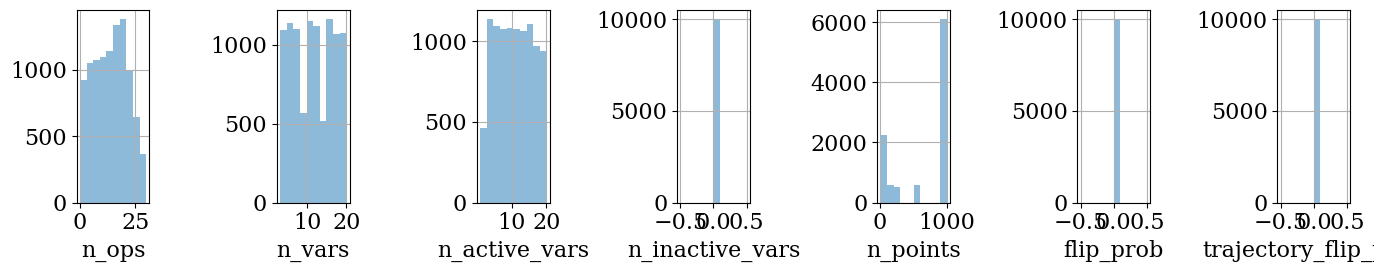

In [5]:
# plot r2_zero vs info_n_points
run = runs[1]
args = run['args']
df = pd.read_csv(args.output_dir/'evals.csv')
info_columns = [col for col in df.columns if col.startswith('info_')]
fig, axarr = plt.subplots(1, len(info_columns), figsize=(14,3))
# plot histograms for all info columns
for i, col in enumerate(info_columns):
    df[col].hist(ax=axarr[i], alpha=0.5, label=col)
    axarr[i].set_xlabel("_".join(col.split('_')[1:]))
plt.tight_layout()
plt.show()

In [6]:
run = runs[-1]
args = run['args']
df = pd.read_csv(args.output_dir/'evals.csv')
#df = pd.read_csv(args.output_dir/'evals_all/eval_pmlb.csv')
df = df.query('info_n_active_vars==8')
#df = df.query('test_error==0')
#df = df.query('acc=1')
for i, (_, sample) in enumerate(df.iterrows()):
    if i==5: break
    true, pred = sample['tree'], sample['predicted_tree']
    print(sample['test_error'], sample['acc'])
    print(true)
    print(pred)
    # true_vars = [match.group() for match in re.finditer(r'x_\w+', true)]
    # pred_vars = [match.group() for match in re.finditer(r'x_\w+', pred)]
    # print(sorted(set(true_vars),key=lambda x : int(x.split('_')[-1])))
    # print(sorted(set(pred_vars),key=lambda x : int(x.split('_')[-1])))
    print()

0.0 True
not((x_3 or (not(x_1) and (x_2 and (not(x_4) and (not(x_5) and (not(x_0) or (x_6 or (not(x_2) and (x_7 and (not(x_5) or ((x_1 or not(x_5)) and ((x_2 or (x_3 and (x_4 or (x_2 and x_3)))) and (not(x_2) or x_6))))))))))))))
(not(x_3) and (x_1 or (not(x_2) or (x_4 or (x_5 or (x_0 and not(x_6)))))))

0.0 True
not((not(x_7) or (not(x_0) and (not(x_2) and (not(x_5) and ((not(x_1) or x_6) and ((not(x_3) or (x_7 or (not(x_1) and (x_4 or x_6)))) and (x_4 or (not(x_3) and (not(x_1) or x_4))))))))))
(x_7 and (x_0 or (x_2 or (x_5 or ((x_1 and (not(x_4) or not(x_6))) or (x_3 and not(x_4)))))))

0.0 True
not((not(x_2) or (x_3 or (x_7 or (not(x_6) and (x_5 or (not(x_0) and (x_1 and x_4))))))))
(x_2 and (not(x_3) and (not(x_7) and (x_6 or (not(x_5) and (x_0 or (not(x_1) or not(x_4))))))))

0.0 True
not((not(x_2) and (not(x_5) and ((not(x_1) or (x_3 or x_7)) and (not(x_1) or ((not(x_0) and x_6) or (not(x_2) and (x_6 and (x_4 or (not(x_5) or x_7))))))))))
(x_2 or (x_5 or (x_1 and (not(x_6) or (n

# Loading the model

In [7]:
run = selected_runs[0]
args = run['args']
new_args =  {
    'eval_size':0,
    'dump_path':args.dump_path.replace('/sb_u0621_liac_scratch','/data/rcp'),
}

env, modules, trainer, evaluator = load_run(args, new_args)

<module 'src' from '/data/rcp/boolean/src/__init__.py'>


Reloading checkpoint from /data/rcp/boolean/experiments/max_vars/exp_max_active_vars_10/checkpoint.pth ...
Reloading checkpoint optimizer ...
Checkpoint reloaded. Resuming at epoch 41 / iteration 192208 ...


# Datasets

## Circuits

In [9]:
from notebook_utils import *
tree, n_vars = get_logical_circuit(function_name='majority_5')
#tree, n_vars = get_boolnet(0, env, verbose=True)

inputs, outputs, val_inputs, val_outputs = generate_data(tree, n_vars=n_vars, n_points=None)

pred_trees, error_arr, complexity_arr = predict(env, modules, inputs, outputs, verbose=False, beam_size=100, beam_type="search", beam_temperature=.1)

test_error_arr = []
for iout, pred_tree in enumerate(pred_trees):
    preds = pred_tree.val(val_inputs[iout])
    test_error = 1.-sum(preds==val_outputs[iout])/len(preds)
    test_error_arr.append(test_error)

print(f"Error, test error, complexity: {error_arr}, {test_error_arr}, {complexity_arr}")
for pred_tree in pred_trees:
    display(env.simplifier.get_simple_infix(pred_tree, simplify_form='basic'))
for i, pred_tree in enumerate(pred_trees):
    print(pred_tree.qtree_prefix())
    print(r'\centering')
    print(r'\begin{forest}')
    print(f"[$y_{i}$ "+pred_tree.forest_prefix()+"]")
    print(r'\end{forest}')

Error, test error, complexity: [0.0], [0.0], [10]


(x_0 | x_3 | (x_1 & x_2 & x_4)) & (x_1 | x_2 | (x_0 & x_3 & x_4)) & (x_4 | (x_0 & x_1 & (x_2 | x_3)) | (x_2 & x_3 & (x_0 | x_1)))

[.$\mathrm{and}$ [.$\mathrm{or}$ [.$x_0$ ][.$\mathrm{or}$ [.$x_3$ ][.$\mathrm{and}$ [.$x_1$ ][.$\mathrm{and}$ [.$x_2$ ][.$x_4$ ]]]]][.$\mathrm{and}$ [.$\mathrm{or}$ [.$x_1$ ][.$\mathrm{or}$ [.$x_2$ ][.$\mathrm{and}$ [.$x_0$ ][.$\mathrm{and}$ [.$x_3$ ][.$x_4$ ]]]]][.$\mathrm{or}$ [.$x_4$ ][.$\mathrm{or}$ [.$\mathrm{and}$ [.$x_0$ ][.$\mathrm{and}$ [.$x_1$ ][.$\mathrm{or}$ [.$x_2$ ][.$x_3$ ]]]][.$\mathrm{and}$ [.$x_2$ ][.$\mathrm{and}$ [.$x_3$ ][.$\mathrm{or}$ [.$x_0$ ][.$x_1$ ]]]]]]]]
\centering
\begin{forest}
[$y_0$ [$\mathrm{and}$ [$\mathrm{or}$ [$x_0$ ][$x_3$ ][$\mathrm{and}$ [$x_1$ ][$x_2$ ][$x_4$ ]]][$\mathrm{or}$ [$x_1$ ][$x_2$ ][$\mathrm{and}$ [$x_0$ ][$x_3$ ][$x_4$ ]]][$\mathrm{or}$ [$x_4$ ][$\mathrm{and}$ [$x_0$ ][$x_1$ ][$\mathrm{or}$ [$x_2$ ][$x_3$ ]]][$\mathrm{and}$ [$x_2$ ][$x_3$ ][$\mathrm{or}$ [$x_0$ ][$x_1$ ]]]]]]
\end{forest}


In [65]:
for x,y,z in zip(val_inputs[0], val_outputs[0], preds):
    print(x.astype(int), y, z)

[0 1 1 0] True True
[1 0 1 1] False False
[1 1 0 0] True True
[0 0 0 0] True True
[1 1 1 1] True True
[1 0 1 0] True True
[1 0 0 1] True True
[1 1 1 0] False False
[0 0 0 1] False False
[1 1 0 1] False False
[1 0 0 0] False False
[0 0 1 0] False False
[0 0 1 1] True True
[0 1 0 0] False False
[0 1 0 1] True True
[0 1 1 1] False False


## Drug discovery

Problem: TOX


  0%|          | 0/5 [00:00<?, ?it/s]

Best f1: 0.433, acc: 0.864, complexity: 2
[.$\mathrm{and}$ [.$\mathrm{not}$ [.$\substack{\text{Presence of} \\ \text{a charged} \\ \text{atom or} \\ \text{group}}$ ]][.$\substack{\text{Presence of} \\ \text{an N} \\ \text{separated from} \\ \text{a CH2} \\ \text{group by} \\ \text{any two} \\ \text{bonds}}$ ]]


bit111 & ~bit49

 20%|██        | 1/5 [00:10<00:40, 10.15s/it]

Best f1: 0.470, acc: 0.842, complexity: 7
[.$\mathrm{not}$ [.$\mathrm{or}$ [.$\substack{\text{Presence of} \\ \text{a charged} \\ \text{atom or} \\ \text{group}}$ ][.$\mathrm{not}$ [.$\mathrm{and}$ [.$\mathrm{or}$ [.$\substack{\text{Presence of} \\ \text{an N} \\ \text{separated from} \\ \text{a CH2} \\ \text{group by} \\ \text{any two} \\ \text{bonds}}$ ][.$\mathrm{or}$ [.$\substack{\text{Presence of} \\ \text{more than} \\ \text{three O} \\ \text{atoms}}$ ][.$\substack{\text{Presence of} \\ \text{an atom} \\ \text{bonded to} \\ \text{3 other} \\ \text{atoms, one} \\ \text{of which} \\ \text{is a} \\ \text{halogen}}$ ]]][.$\mathrm{or}$ [.$\substack{\text{Presence of} \\ \text{an N} \\ \text{separated from} \\ \text{a CH2} \\ \text{group by} \\ \text{any two} \\ \text{bonds}}$ ][.$\substack{\text{Presence of} \\ \text{an N} \\ \text{bonded to} \\ \text{at least} \\ \text{one H}}$ ]]]]]]


~(bit49 | ~((bit111 | bit151) & (bit107 | bit111 | bit140)))

 40%|████      | 2/5 [00:22<00:33, 11.25s/it]

Best f1: 0.462, acc: 0.846, complexity: 10
[.$\mathrm{not}$ [.$\mathrm{or}$ [.$\substack{\text{Presence of} \\ \text{a charged} \\ \text{atom or} \\ \text{group}}$ ][.$\mathrm{and}$ [.$\mathrm{not}$ [.$\substack{\text{Presence of} \\ \text{an atom} \\ \text{bonded to} \\ \text{another atom} \\ \text{by a} \\ \text{ring bond} \\ \text{and bonded} \\ \text{to N} \\ \text{by a} \\ \text{chain bond}}$ ]][.$\mathrm{and}$ [.$\mathrm{not}$ [.$\substack{\text{Presence of} \\ \text{a heteroatom} \\ \text{bonded to} \\ \text{at least} \\ \text{two CH2} \\ \text{carbons}}$ ]][.$\mathrm{and}$ [.$\mathrm{not}$ [.$\substack{\text{Presence of} \\ \text{a CH2} \\ \text{group bonded} \\ \text{to another} \\ \text{atom and} \\ \text{a heteroatom} \\ \text{that is} \\ \text{bonded to} \\ \text{at least} \\ \text{one H}}$ ]][.$\mathrm{or}$ [.$\substack{\text{Presence of} \\ \text{an atom} \\ \text{with at} \\ \text{least four} \\ \text{neighbors}}$ ][.$\mathrm{not}$ [.$\substack{\text{Presence of} \\ \tex

~(bit49 | (~bit133 & ~bit82 & ~bit86 & (bit112 | ~bit146)))

 60%|██████    | 3/5 [00:36<00:25, 12.81s/it]

Best f1: 0.468, acc: 0.868, complexity: 7
[.$\mathrm{and}$ [.$\mathrm{not}$ [.$\substack{\text{Presence of} \\ \text{a charged} \\ \text{atom or} \\ \text{group}}$ ]][.$\mathrm{or}$ [.$\substack{\text{Presence of} \\ \text{a heteroatom} \\ \text{bonded to} \\ \text{at least} \\ \text{two CH2} \\ \text{carbons}}$ ][.$\mathrm{or}$ [.$\mathrm{not}$ [.$\mathrm{or}$ [.$\substack{\text{Presence of} \\ \text{multiple heterocyclic} \\ \text{atoms}}$ ][.$\substack{\text{Presence of} \\ \text{an atom} \\ \text{with at} \\ \text{least four} \\ \text{neighbors}}$ ]]][.$\mathrm{and}$ [.$\substack{\text{Presence of} \\ \text{an atom} \\ \text{with at} \\ \text{least four} \\ \text{neighbors}}$ ][.$\substack{\text{Presence of} \\ \text{an atom} \\ \text{bonded to} \\ \text{another atom} \\ \text{by a} \\ \text{ring bond} \\ \text{and bonded} \\ \text{to N} \\ \text{by a} \\ \text{chain bond}}$ ]]]]]


~bit49 & (bit86 | (bit112 & bit133) | ~(bit112 | bit120))

 80%|████████  | 4/5 [00:52<00:14, 14.13s/it]

Best f1: 0.456, acc: 0.804, complexity: 6
[.$\mathrm{not}$ [.$\mathrm{or}$ [.$\substack{\text{Presence of} \\ \text{a charged} \\ \text{atom or} \\ \text{group}}$ ][.$\mathrm{not}$ [.$\mathrm{or}$ [.$\substack{\text{Presence of} \\ \text{a heteroatom} \\ \text{in a} \\ \text{6M ring}}$ ][.$\mathrm{or}$ [.$\substack{\text{Presence of} \\ \text{an O} \\ \text{separated from} \\ \text{another O} \\ \text{by any} \\ \text{4 bonds}}$ ][.$\mathrm{or}$ [.$\substack{\text{Presence of} \\ \text{a CH2} \\ \text{group bonded} \\ \text{to another} \\ \text{atom and} \\ \text{a heteroatom} \\ \text{that is} \\ \text{bonded to} \\ \text{at least} \\ \text{one H}}$ ][.$\substack{\text{Presence of} \\ \text{an atom} \\ \text{bonded to} \\ \text{another atom} \\ \text{by a} \\ \text{ring bond} \\ \text{and bonded} \\ \text{to N} \\ \text{by a} \\ \text{chain bond}}$ ]]]]]]]


~(bit49 | ~(bit133 | bit82 | bit89 | bit98))

100%|██████████| 5/5 [01:10<00:00, 14.19s/it]

Problem: BBB



  0%|          | 0/5 [00:00<?, ?it/s]

Best f1: 0.900, acc: 0.840, complexity: 2
[.$\mathrm{not}$ [.$\mathrm{and}$ [.$\substack{\text{Presence of} \\ \text{an N} \\ \text{seperated from} \\ \text{an O} \\ \text{by any} \\ \text{3 bonds}}$ ][.$\substack{\text{Presence of} \\ \text{a C} \\ \text{bonded to} \\ \text{two O} \\ \text{atoms}}$ ]]]


~(bit123 & bit95)

 20%|██        | 1/5 [00:10<00:43, 10.94s/it]

Best f1: 0.891, acc: 0.834, complexity: 5
[.$\mathrm{not}$ [.$\mathrm{and}$ [.$\substack{\text{Presence of} \\ \text{multiple heteroatoms} \\ \text{bonded to} \\ \text{at least} \\ \text{one H} \\ \text{atom}}$ ][.$\mathrm{or}$ [.$\substack{\text{Presence of} \\ \text{an atom} \\ \text{at an} \\ \text{aromatic or} \\ \text{non aromatic} \\ \text{boundary}}$ ][.$\mathrm{or}$ [.$\substack{\text{Presence of} \\ \text{a heteroatom} \\ \text{bonded to} \\ \text{at least} \\ \text{three neighbors}}$ ][.$\mathrm{and}$ [.$\substack{\text{Presence of} \\ \text{multiple heteroatoms} \\ \text{bonded to} \\ \text{at least} \\ \text{one H} \\ \text{atom}}$ ][.$\substack{\text{Presence of} \\ \text{a heteroatom} \\ \text{bonded to} \\ \text{a methyl} \\ \text{C}}$ ]]]]]]


~(bit131 & (bit144 | bit148 | (bit131 & bit93)))

 40%|████      | 2/5 [00:24<00:36, 12.32s/it]

Best f1: 0.895, acc: 0.838, complexity: 4
[.$\mathrm{or}$ [.$\mathrm{not}$ [.$\substack{\text{Presence of} \\ \text{multiple heteroatoms} \\ \text{bonded to} \\ \text{at least} \\ \text{one H} \\ \text{atom}}$ ]][.$\mathrm{and}$ [.$\mathrm{not}$ [.$\substack{\text{Presence of} \\ \text{an N} \\ \text{seperated from} \\ \text{an O} \\ \text{by any} \\ \text{3 bonds}}$ ]][.$\substack{\text{Presence of} \\ \text{a heteroatom} \\ \text{separated from} \\ \text{a CH2} \\ \text{group by} \\ \text{any 3} \\ \text{bonds}}$ ]]]


~bit131 | (bit90 & ~bit95)

 60%|██████    | 3/5 [00:39<00:27, 13.58s/it]

Best f1: 0.875, acc: 0.808, complexity: 7
[.$\mathrm{not}$ [.$\mathrm{or}$ [.$\mathrm{and}$ [.$\substack{\text{Presence of} \\ \text{a hydroxy} \\ \text{oxygen (OH)}}$ ][.$\substack{\text{Presence of} \\ \text{an N} \\ \text{seperated from} \\ \text{an O} \\ \text{by any} \\ \text{4 bonds}}$ ]][.$\mathrm{and}$ [.$\mathrm{not}$ [.$\substack{\text{Presence of} \\ \text{an N} \\ \text{seperated from} \\ \text{an O} \\ \text{by any} \\ \text{4 bonds}}$ ]][.$\mathrm{and}$ [.$\mathrm{not}$ [.$\substack{\text{Presence of} \\ \text{a tertiary} \\ \text{C}}$ ]][.$\substack{\text{Presence of} \\ \text{multiple heteroatoms} \\ \text{bonded to} \\ \text{at least} \\ \text{one H} \\ \text{atom}}$ ]]]]]


~((bit139 & bit97) | (bit131 & ~bit66 & ~bit97))

 80%|████████  | 4/5 [00:56<00:14, 14.84s/it]

Best f1: 0.881, acc: 0.818, complexity: 6
[.$\mathrm{not}$ [.$\mathrm{or}$ [.$\mathrm{and}$ [.$\substack{\text{Presence of} \\ \text{multiple heteroatoms} \\ \text{bonded to} \\ \text{at least} \\ \text{one H} \\ \text{atom}}$ ][.$\mathrm{or}$ [.$\substack{\text{Presence of} \\ \text{an atom} \\ \text{at an} \\ \text{aromatic or} \\ \text{non aromatic} \\ \text{boundary}}$ ][.$\mathrm{and}$ [.$\substack{\text{Presence of} \\ \text{multiple heteroatoms} \\ \text{bonded to} \\ \text{at least} \\ \text{one H} \\ \text{atom}}$ ][.$\substack{\text{Presence of} \\ \text{an atom} \\ \text{bonded to} \\ \text{O by} \\ \text{a non} \\ \text{aromatic bond} \\ \text{and bonded} \\ \text{to another} \\ \text{atom aromatically}}$ ]]]][.$\mathrm{and}$ [.$\substack{\text{Presence of} \\ \text{an N} \\ \text{seperated from} \\ \text{an O} \\ \text{by any} \\ \text{4 bonds}}$ ][.$\substack{\text{Presence of} \\ \text{more than} \\ \text{three O} \\ \text{atoms}}$ ]]]]


~((bit140 & bit97) | (bit131 & (bit144 | (bit113 & bit131))))

100%|██████████| 5/5 [01:15<00:00, 15.05s/it]


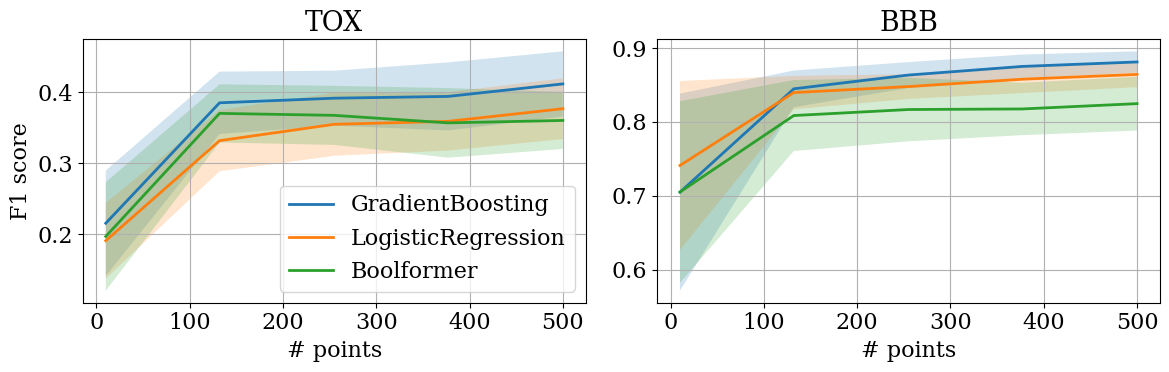

In [60]:
from notebook_utils import *

num_points = 100
beam_size  = 20
verbose = True
num_points_arr = np.linspace(10,500,5).astype(int)
#num_points_arr = [1,10,30]
problems = ['TOX','BBB']
fig, axarr = plt.subplots(1,len(problems),figsize=(6*len(problems),4))
for ip, problem in enumerate(problems):
    print('Problem:', problem, flush=True)
    accs, f1s, accs_var, f1s_var = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
    for num_points in tqdm.tqdm(num_points_arr):
        accs_tmp, f1s_tmp, trees = defaultdict(list), defaultdict(list), []
        # multiprocessing

        for seed in range(50):
            acc, f1, tree = run_drug_discovery(env, modules, problem=problem, num_points=num_points, num_test_points=500, num_features=args.max_inactive_vars, beam_size=beam_size, verbose=False, balance=True)
            #except: print('fail');  
            for k, v in acc.items(): accs_tmp[k].append(v)
            for k, v in f1.items(): f1s_tmp[k].append(v)
            trees.append(tree)
        # tree with best acc
        idx = np.argmax(f1s_tmp['Boolformer'])
        best_tree = trees[idx]
        best_f1, best_acc = f1s_tmp['Boolformer'][idx], accs_tmp['Boolformer'][idx]
        if verbose:
            print(f'Best f1: {best_f1:.3f}, acc: {best_acc:.3f}, complexity: {best_tree.get_n_ops()}')
            #print(f"[.${problem}$ "+tree_to_latex(best_tree)+"]", flush=True)
            print(tree_to_latex(best_tree), flush=True)
            display(env.simplifier.get_simple_infix(best_tree, simplify_form='basic'))
        for k, v in accs_tmp.items(): 
            accs[k].append(np.mean(v))
            accs_var[k].append(np.std(v))
        for k, v in f1s_tmp.items(): 
            f1s[k].append(np.mean(v))
            f1s_var[k].append(np.std(v))

    # create grouped bar plot
    #barWidth = 0.25
    #for i, (k, v) in enumerate(accs.items()):
    #    r1 = np.arange(len(num_points_arr))+ i*barWidth
    #    axarr[ip].bar(r1, v, yerr=accs_var[k], width=barWidth, label=k.replace('Classifier', ''))
        
    for k, v in f1s.items():
        axarr[ip].    errorbar(num_points_arr, v,  label=k.replace('Classifier', ''))
        axarr[ip].fill_between(num_points_arr, np.array(v)-np.array(f1s_var[k]), np.array(v)+np.array(f1s_var[k]), alpha=0.2)
    axarr[ip].set_xlabel('# points')
    axarr[ip].set_title(problem)
    #axarr[ip].set_xscale('log')

axarr[0].set_ylabel('F1 score')
axarr[0].legend()
plt.tight_layout()
plt.savefig(savedir+'drug_discovery_maccs.pdf')
plt.show()



## PLMB

In [15]:
from pmlb import fetch_data
df = pd.read_csv('all_summary_stats.tsv', sep='\t')
df = df[df['n_binary_features']>=4]
#df = df[df['n_categorical_features']==0]
df = df[df['n_classes']==2]
display(df)
dataset_names = df.dataset 

for i, dataset in enumerate(dataset_names):
    #if dataset != 'kr_vs_kp': continue
    if dataset not in ['mofn_3_7_10', 'threeOf9', 'xd6']: continue
    run_pmlb(env, modules, dataset, beam_size=50, n_points=1024)
    #if i==0: break
    

,dataset,n_instances,n_features,n_binary_features,n_categorical_features,n_continuous_features,endpoint_type,n_classes,imbalance,task
120,GAMETES_Epistasis_2_Way_1000atts_0.4H_EDM_1_ED...,1600,1000,31,969,0,categorical,2.0,0.000000,classification
129,agaricus_lepiota,8145,22,5,16,1,categorical,2.0,0.001458,classification
144,analcatdata_fraud,42,11,10,1,0,categorical,2.0,0.145125,classification
151,australian,690,14,4,3,7,categorical,2.0,0.012132,classification
153,backache,180,32,22,4,6,categorical,2.0,0.521605,classification
167,chess,3196,36,35,1,0,categorical,2.0,0.001974,classification
176,coil2000,9822,85,5,79,1,categorical,2.0,0.775590,classification
182,corral,160,6,6,0,0,categorical,2.0,0.015625,classification
188,dis,3772,29,19,4,6,categorical,2.0,0.939440,classification
312,flare,1066,10,4,6,0,categorical,2.0,0.433670,classification



-------------------------------

mofn_3_7_10 (1324, 10) Index(['Bit-0', 'Bit-1', 'Bit-2', 'Bit-3', 'Bit-4', 'Bit-5', 'Bit-6', 'Bit-7',
       'Bit-8', 'Bit-9', 'target'],
      dtype='object')
(300, 10)
{'GradientBoostingClassifier': 0.9741379310344828, 'LogisticRegression': 0.9987468671679198, 'MLPClassifier': 0.9809230769230768, 'Boolformer': 0.9346608587429993}


(x_2 | x_7 | (x_3 & x_6) | (x_5 & (x_2 | x_8 | (x_3 & x_4)))) & (x_5 | x_8 | (x_6 & (x_3 | x_4)) | (x_4 & (x_3 | x_6 | x_9)))

\begin{forest}
[$\text{mofn3710}$ [$\mathrm{and}$ [$\mathrm{or}$ [$\substack{\text{Bit-2}}$ ][$\substack{\text{Bit-7}}$ ][$\mathrm{and}$ [$\substack{\text{Bit-3}}$ ][$\substack{\text{Bit-6}}$ ]][$\mathrm{and}$ [$\substack{\text{Bit-5}}$ ][$\mathrm{or}$ [$\substack{\text{Bit-2}}$ ][$\substack{\text{Bit-8}}$ ][$\mathrm{and}$ [$\substack{\text{Bit-3}}$ ][$\substack{\text{Bit-4}}$ ]]]]][$\mathrm{or}$ [$\substack{\text{Bit-5}}$ ][$\substack{\text{Bit-8}}$ ][$\mathrm{and}$ [$\substack{\text{Bit-4}}$ ][$\mathrm{or}$ [$\substack{\text{Bit-3}}$ ][$\substack{\text{Bit-6}}$ ][$\substack{\text{Bit-9}}$ ]]][$\mathrm{and}$ [$\substack{\text{Bit-6}}$ ][$\mathrm{or}$ [$\substack{\text{Bit-3}}$ ][$\substack{\text{Bit-4}}$ ]]]]]]
\end{forest}
\caption{mofn3710. F1: 0.935. LogReg: 0.999. GradientBoost: 0.974.}

-------------------------------

threeOf9 (512, 9) Index(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'target'], dtype='object')
(300, 9)
{'GradientBoostingClassifier': 0.99009900990099,

(x_1 & x_2 & (x_0 | x_3)) | (x_3 & x_4 & (x_2 | x_5)) | (x_6 & (x_5 | x_8) & (x_7 | (x_4 & x_5)))

\begin{forest}
[$\text{threeOf9}$ [$\mathrm{or}$ [$\mathrm{and}$ [$\substack{\text{F2}}$ ][$\substack{\text{F3}}$ ][$\mathrm{or}$ [$\substack{\text{F1}}$ ][$\substack{\text{F4}}$ ]]][$\mathrm{and}$ [$\substack{\text{F4}}$ ][$\substack{\text{F5}}$ ][$\mathrm{or}$ [$\substack{\text{F3}}$ ][$\substack{\text{F6}}$ ]]][$\mathrm{and}$ [$\substack{\text{F7}}$ ][$\mathrm{or}$ [$\substack{\text{F6}}$ ][$\substack{\text{F9}}$ ]][$\mathrm{or}$ [$\substack{\text{F8}}$ ][$\mathrm{and}$ [$\substack{\text{F5}}$ ][$\substack{\text{F6}}$ ]]]]]]
\end{forest}
\caption{threeOf9. F1: 1.000. LogReg: 0.750. GradientBoost: 0.990.}

-------------------------------

xd6 (973, 9) Index(['Attribute 1', 'Attribute 2', 'Attribute 3', 'Attribute 4',
       'Attribute 5', 'Attribute 6', 'Attribute 7', 'Attribute 8',
       'Attribute 9', 'target'],
      dtype='object')
(300, 9)
{'GradientBoostingClassifier': 1.0, 'LogisticRegression': 0.6766917293233081, 'MLPClassifier': 0.8463356973995273, 'Boolformer': 1.0}


(x_0 & x_1 & x_2) | (x_3 & x_4 & x_5) | (x_6 & x_7 & x_8)

\begin{forest}
[$\text{xd6}$ [$\mathrm{or}$ [$\mathrm{and}$ [$\substack{\text{Attribute 1}}$ ][$\substack{\text{Attribute 2}}$ ][$\substack{\text{Attribute 3}}$ ]][$\mathrm{and}$ [$\substack{\text{Attribute 4}}$ ][$\substack{\text{Attribute 5}}$ ][$\substack{\text{Attribute 6}}$ ]][$\mathrm{and}$ [$\substack{\text{Attribute 7}}$ ][$\substack{\text{Attribute 8}}$ ][$\substack{\text{Attribute 9}}$ ]]]]
\end{forest}
\caption{xd6. F1: 1.000. LogReg: 0.677. GradientBoost: 1.000.}


In [50]:
dataset = 'early_stage_diabetes_risk'




-------------------------------

early_stage_diabetes_risk (520, 16) Index(['Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness',
       'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching',
       'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity', 'class'],
      dtype='object')
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
(500, 15)
{'GradientBoostingClassifier': 1.0, 'LogisticRegression': 0.9473684210526316, 'MLPClassifier': 1.0, 'Boolformer': 1.0}


x_2 | ~x_0 | (x_1 & ~(x_10 & x_13))

[.$\text{earlystagediabetesrisk}$ [.$\mathrm{or}$ [.$\mathrm{not}$ [.$\substack{\text{Male}}$ ]][.$\mathrm{or}$ [.$\substack{\text{Polydipsia}}$ ][.$\mathrm{and}$ [.$\substack{\text{Polyuria}}$ ][.$\mathrm{not}$ [.$\mathrm{and}$ [.$\substack{\text{delayed healing}}$ ][.$\substack{\text{Alopecia}}$ ]]]]]]]
\caption{earlystagediabetesrisk. F1: 1.000. Logistic regression: 0.947.}


## UCI

In [59]:
import uci_dataset
methods = [method for method in uci_dataset.__dir__() if method.startswith('load_') and not method.endswith('data')]
for method in methods:
    try:df = getattr(uci_dataset, method)()
    except:print(method+' failed'); continue
    # get number of binary features
    n_features = len(df.columns)-1
    n_binary_features = 0
    for col in df.columns:
        if len(df[col].unique())==2: n_binary_features+=1
    if n_binary_features/n_features>.5: 
        print(method, n_features, n_binary_features)

load_abalone 8 0
load_arrhythmia failed
load_audiology 70 53
FOUND
load_autism_screening 20 15
FOUND
load_blood_transfusion 4 1
load_breast_cancer 9 3
load_breast_cancer_wis_diag 31 1
load_cardiotocography 22 0
load_cervical_cancer 35 10
load_chess 36 36
FOUND
load_chronic_kidney_disease failed
load_climate_crashes 20 1
load_credit_approval 15 4
load_cylinder_bands 39 0
load_dermatology 34 1
load_diabetic 19 4
load_dishonest_users 4 1
load_early_stage_diabetes_risk 16 16
FOUND
load_echocardiogram failed
load_exasens 12 0
load_fertility 9 4
load_haberman 3 1
load_hayes_roth 5 0
load_hcc_survival 49 4
load_hcv 13 1
load_heart_disease 13 3
load_hepatitis 19 4
load_indian_liver 10 2
load_liver_disorders 6 1
load_lymphography 18 9
load_obesity_levels 16 5
load_parkinson 23 1
load_primary_tumor 17 11
FOUND
load_qsar_bioconcentration 13 2
load_thoracic_surgery 16 11
FOUND
load_thyroid_disease 25 18
FOUND
load_wilt 5 1


NameError: name 'run_uci' is not defined

In [61]:
run_uci(env, modules, 'ealy_stage_diabetes_risk')



-------------------------------

ealy_stage_diabetes_risk (520, 16) Index(['Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness',
       'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching',
       'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity', 'class'],
      dtype='object')
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
(500, 15)
{'GradientBoostingClassifier': 1.0, 'LogisticRegression': 1.0, 'MLPClassifier': 1.0, 'Boolformer': 1.0}


~(x_0 & ~x_2 & (~x_1 | (x_10 & ~x_6)))

[.$\text{ealystagediabetesrisk}$ [.$\mathrm{not}$ [.$\mathrm{and}$ [.$\substack{\text{Male}}$ ][.$\mathrm{and}$ [.$\mathrm{not}$ [.$\substack{\text{Polydipsia}}$ ]][.$\mathrm{or}$ [.$\mathrm{not}$ [.$\substack{\text{Polyuria}}$ ]][.$\mathrm{and}$ [.$\substack{\text{delayed healing}}$ ][.$\mathrm{not}$ [.$\substack{\text{Genital thrush}}$ ]]]]]]]]
\caption{ealystagediabetesrisk. F1: 1.000. Logistic regression: 1.000.}


## Gene regulatory

In [ ]:
pred_trees, inputs, outputs = run_benchmark(env, modules, network_size=16, stop_at=1, verbose=True, beam_size=1, organism='Synthetic')
for i, pred_tree in enumerate(pred_trees):
    display(env.simplifier.get_simple_infix(pred_tree, simplify_form="basic"))

# Attention maps

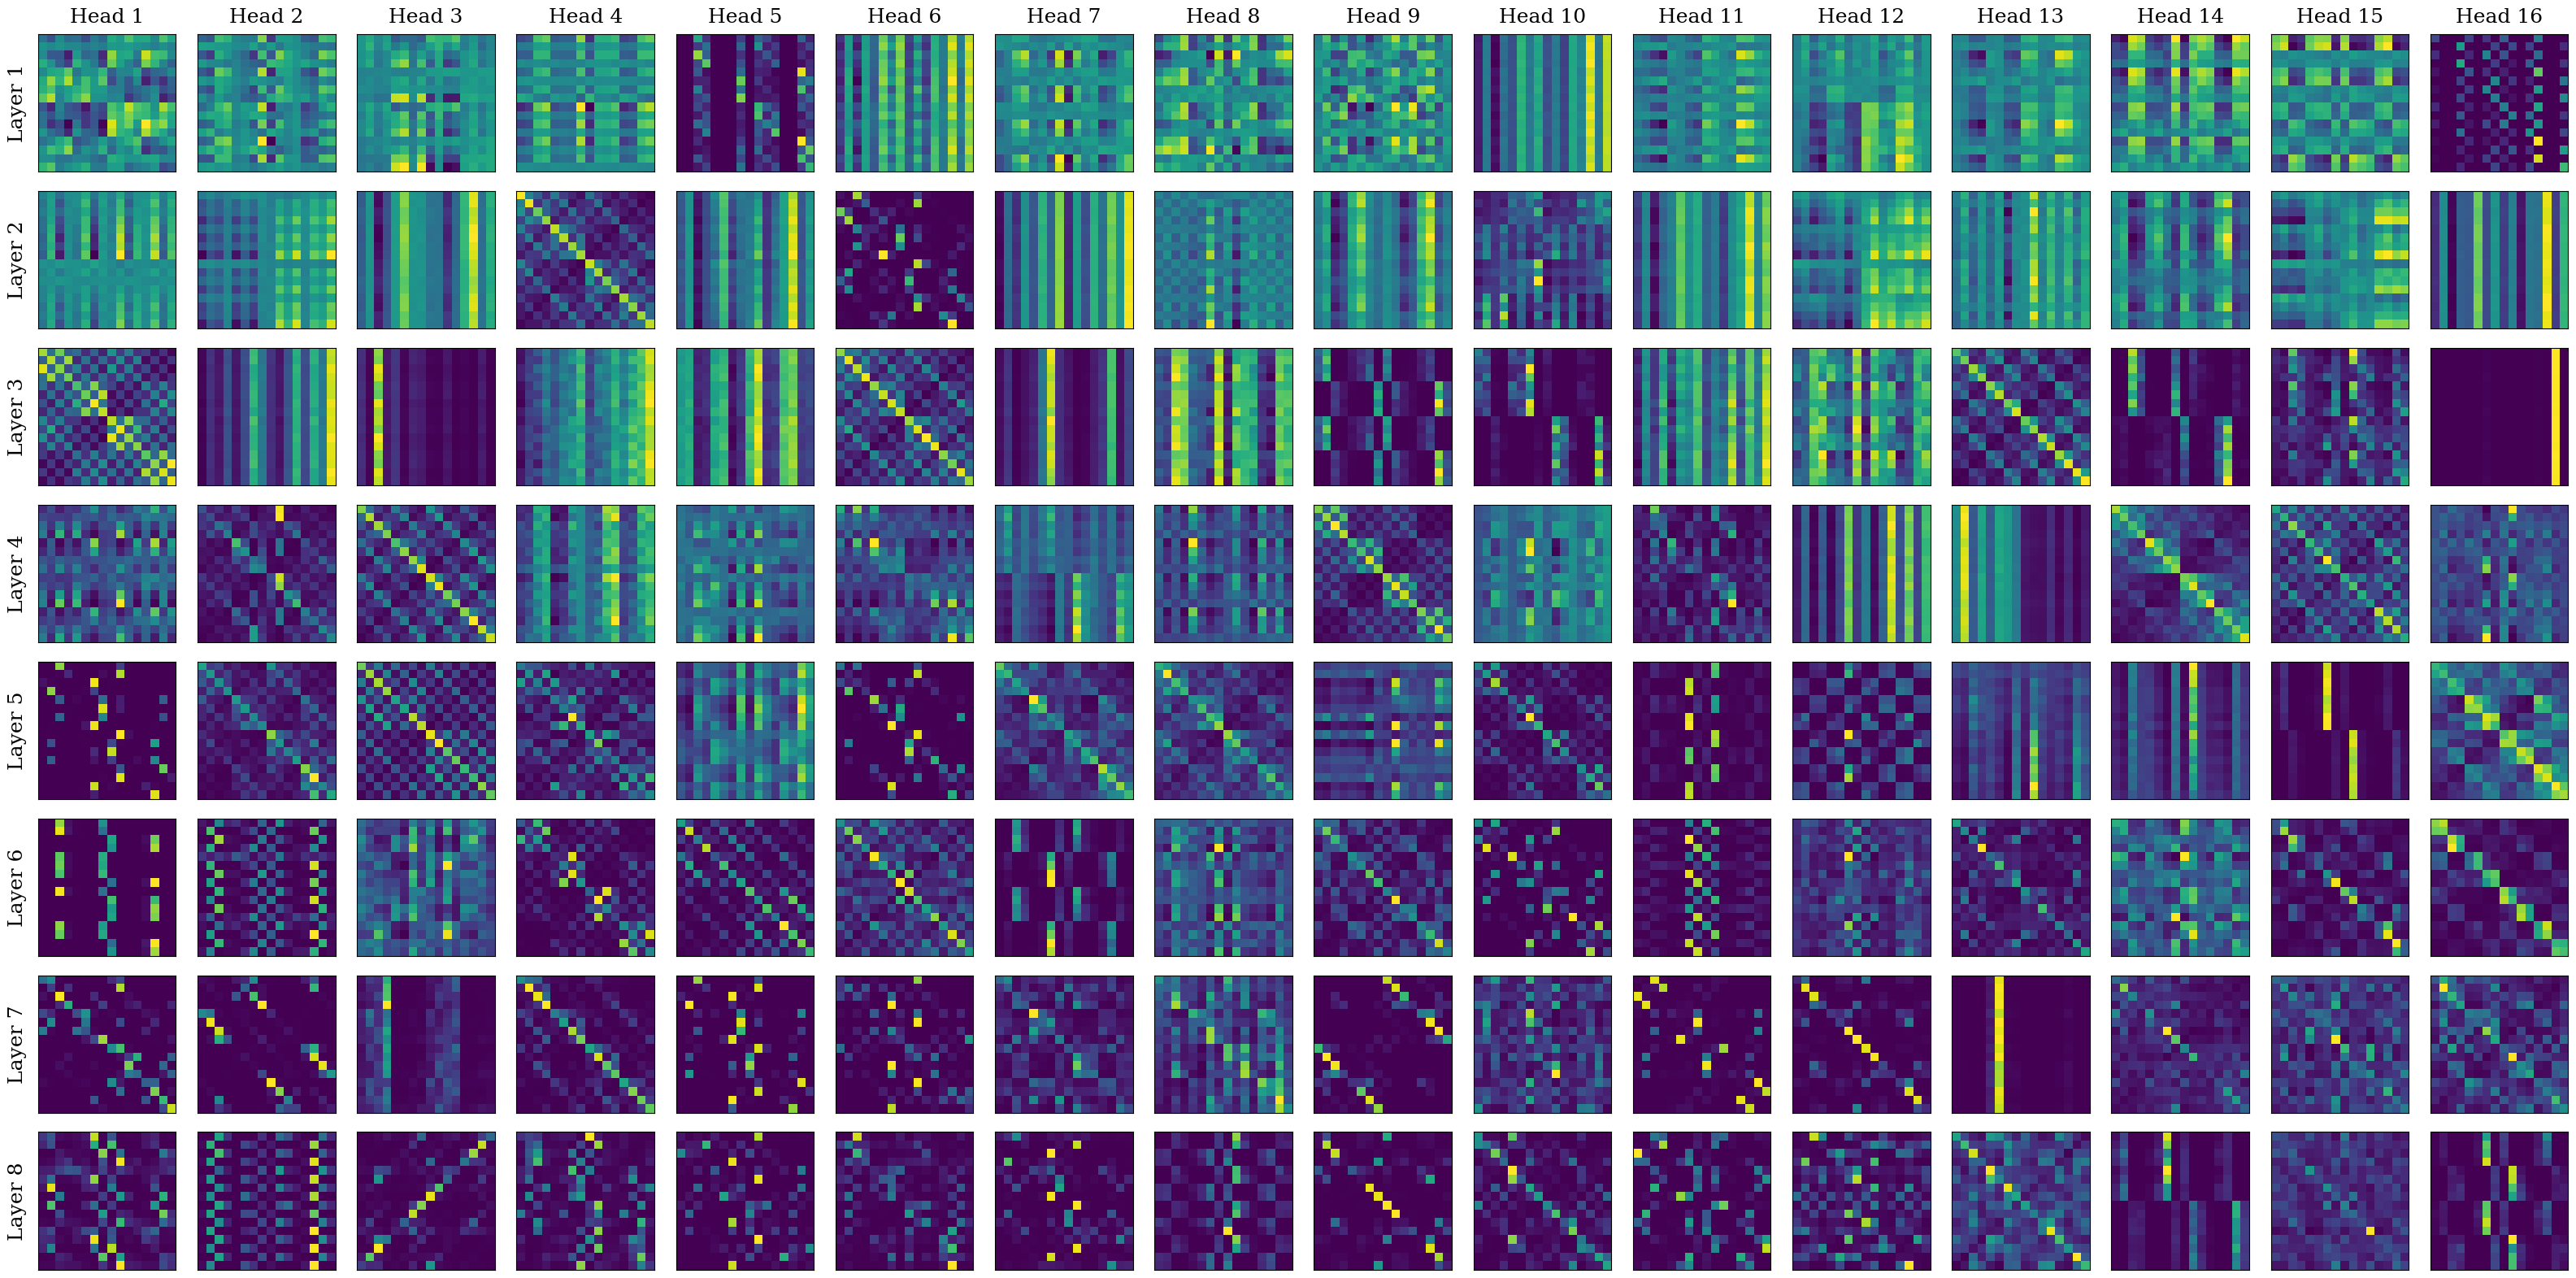

In [17]:
function_name = 'random_4'
tree, n_vars = get_logical_circuit(function_name=function_name)
inputs, outputs, val_inputs, val_outputs = generate_data(tree, n_vars=n_vars, n_points=None, train_ratio=1)

fig, axarr = plot_attention(args, env, modules, inputs, outputs)
plt.tight_layout()
plt.savefig(savedir+f'attention_{function_name}.pdf')
plt.show()

# Embeddings

(1024, 10) (1024,)


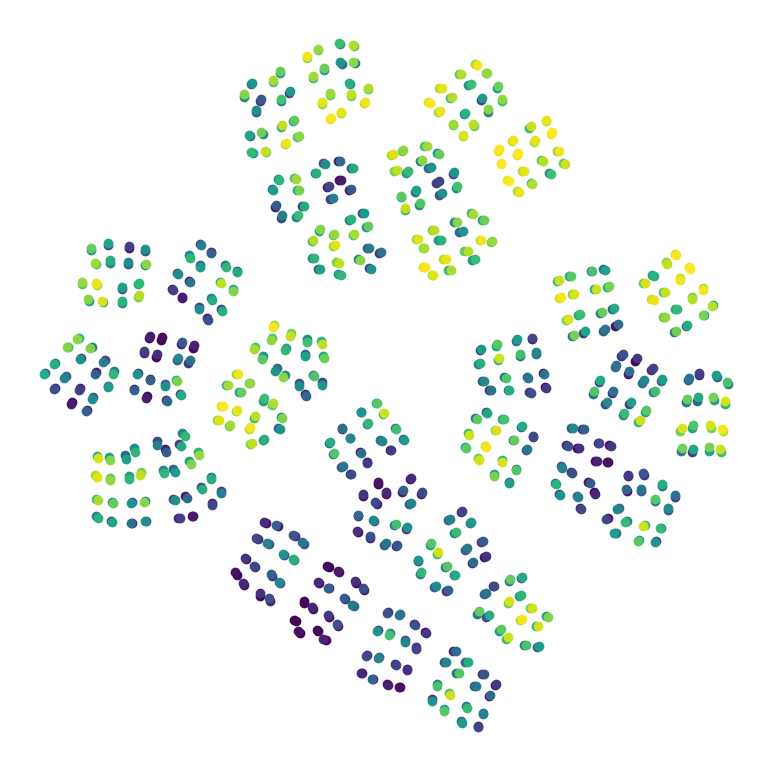

In [ ]:
embedder = modules["embedder"]  
n_vars = [10]
inputs = []
for n_var in n_vars:
    truth_table = get_truth_table(n_var)
    inputs.extend(truth_table)
inputs = np.array(inputs)
outputs = np.array([False for _ in range(len(inputs))])
idx = np.argsort(inputs.sum(axis=1))
inputs = inputs[idx]
print(inputs.shape, outputs.shape)
inputs, outputs = [inputs], [outputs]
embeddings = get_embeddings(embedder, inputs, outputs)

fig = tsne_plot_2d(embeddings)
plt.savefig(savedir+'embeddings.pdf')
plt.show()

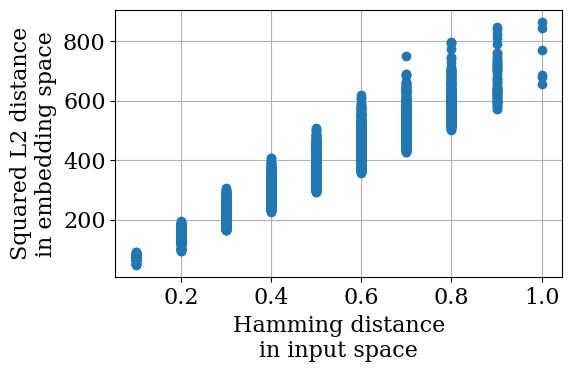

In [ ]:
embedder = modules["embedder"]  

distance1, distance2 = [], []
n_vars = [10]
inputs = []
for n_var in n_vars:
    truth_table = np.array(np.meshgrid(*([np.array([True, False])] * n_var))).T.reshape(-1, n_var)
    inputs.extend(truth_table)
inputs = np.array(inputs)
outputs = np.array([False for _ in range(len(inputs))])
inputs, outputs = [inputs], [outputs]

embeddings = get_embeddings(embedder, inputs, outputs)
for i in range(len(embeddings))[::100]:
    for j in range(i+1, len(embeddings)):
        # hamming distance
        d1 = np.sum(inputs[0][i]!=inputs[0][j])/n_vars
        # euclidean distance
        d2 = np.linalg.norm(embeddings[i]-embeddings[j])**2
        distance1.append(d1)
        distance2.append(d2)

plt.figure(figsize=(6, 4))
plt.plot(distance1, distance2, 'o')
plt.xlabel('Hamming distance\nin input space')
plt.ylabel('Squared L2 distance\nin embedding space')
plt.tight_layout()
plt.savefig(savedir+'distance.pdf')
plt.show()

# Playing with generator

In [ ]:
#%%timeit
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path
from sympy import *
import argparse

%load_ext autoreload
%autoreload 2
#%cd ~/recur/notebooks
sys.path.append('/data/rcp/boolean')
import src
from src.envs.generators import RandomRecurrence
from src.envs.encoders import  Equation, Boolean
from src.envs.recurrence import RecurrenceEnvironment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
parser = argparse.ArgumentParser(description="Function prediction", add_help=False)
RecurrenceEnvironment.register_args(parser)  
params = parser.parse_args(args=[])
params.operators_to_use = 'and,or,not'
params.simplify_form = "boolean_package"
#params.debug=False
params.min_active_vars = 1
params.max_active_vars = 10
params.max_inactive_vars = 0
params.max_ops=200
params.max_points = 1000
params.input_truth_table = True
params.max_flip_prob = 0
    
generator = RandomRecurrence(params)
env = RecurrenceEnvironment(params)
env.rng = np.random.RandomState(0)

lengths, n_rejected, n_accepted = [], 0, 0
i = 0
while True:
    if i==10: break
    res = env._gen_expr(True, n_active_vars=10, n_ops=None)
    if res is None: 
        n_rejected+=1
        continue
    n_accepted+=1
    inputs,outputs,val_inputs,val_outputs,tree,info = res
    print(outputs.mean(), len(tree.prefix().split(',')))
    #print(sum(outputs)/len(outputs))
    i+=1
    lengths.append(tree.get_n_ops())
    display(env.simplifier.get_simple_infix(tree, simplify_form='basic'))
print(np.mean(lengths))
print(n_rejected/(n_rejected+n_accepted))

0.392 31


~(x_5 & x_8) & (x_0 | (x_2 & x_7 & ~x_1 & (x_6 | (x_0 & x_1 & x_2 & x_5 & ~x_4 & ~(x_8 | x_9)))))

0.604 98


~(~(x_0 | x_9) | (x_2 & (~x_4 | (x_3 & (x_6 | x_7))) & (~(x_1 | x_8) | (x_5 & (x_7 | x_9) & (x_2 | ~x_6 | (~x_7 & (x_9 | ~x_4)) | (x_3 & x_8 & (~x_5 | (x_1 & x_3) | ((x_1 | (x_4 & (x_9 | ~x_6 | ~x_8))) & (~x_3 | (x_0 & x_1 & (x_8 | ~x_5 | (x_0 & x_9)))) & (x_0 | (x_7 & ~x_5 & (x_4 | (x_2 & x_9 & ~x_6 & ~x_7))))))))))))

0.774 73


x_3 | ~x_1 | (~x_2 & ((x_9 & ~x_0 & ~x_7 & ~(x_4 & x_6 & x_8)) | (x_5 & x_7 & (~x_6 | (x_2 & x_8 & ~x_0 & ~(x_4 & x_6))) & (x_1 | (x_0 & (~x_9 | (x_8 & ~x_1 & (x_3 | ~x_9 | (x_6 & (x_4 | ~x_1 | ((x_4 | x_5) & (x_6 | x_7))))))))))))

0.753 50


x_0 | ((~x_6 | (x_1 & ~x_9)) & (~x_5 | (x_7 & (x_8 | (x_5 & ~x_4 & (x_0 | ~x_3 | (x_2 & x_8))))) | (~x_2 & (x_6 | x_9 | ~x_0 | ~x_5 | ~(x_3 | (x_4 & x_9))))))

0.508 18


x_4 | (x_0 & x_7 & ~x_1 & ~x_2 & (~x_6 | (x_3 & x_9)))

0.068 115


x_0 & x_7 & ~x_2 & (x_3 | ~x_1) & (x_4 | x_5 | x_8 | (x_6 & ~(x_2 & x_3))) & (~x_6 | ~x_9 | (x_5 & ~x_0 & ~x_7 & ((x_0 & ~x_9) | (~x_4 & (x_5 | x_9)))) | (~x_7 & ((x_2 & x_6 & (x_5 | x_7)) | (x_2 & ~x_1 & ~(x_3 | x_9)))) | (x_4 & (~(x_5 | x_9) | (x_5 & ((x_1 & (x_6 | x_7)) | (~(x_5 & x_9) & (~x_8 | (~x_2 & (x_0 | x_5 | ~x_1) & (x_1 | (x_9 & ~(x_2 & (x_6 | x_9))))))))))))

0.981 24


~(x_4 & x_7 & x_8 & ~x_6 & ~x_9 & (x_2 | x_3) & (x_0 | x_5 | (x_1 & x_2)))

0.568 9


~x_6 | (x_0 & x_3 & ~x_4)

0.5 33


x_7 & (x_4 | x_5 | x_8 | ~x_2 | (x_1 & x_3) | (x_9 & ~(x_2 & x_5 & x_7)) | (x_7 & (x_6 | ~x_0 | ~x_5)))

0.042 21


~(x_0 | x_7 | ~x_2 | ~x_4 | (x_3 & x_5) | (x_1 & x_6 & ~x_8))

26.8
0.16666666666666666


In [ ]:
import boolean
def simplify(tree):
    algebra = boolean.BooleanAlgebra()
    expr = algebra.parse(str(env.simplifier.get_simple_infix(tree)))
    return expr.simplify()

tree = trees[4]
tree1 = env.simplifier.get_simple_infix(tree, simplify_form="none")
tree2 = env.simplifier.get_simple_infix(tree, simplify_form="basic")
tree3 = env.simplifier.get_simple_infix(tree, simplify_form="shortest")
tree4 = env.simplifier.get_simple_infix(tree, simplify_form="boolean_package")
for tree_ in [tree1, tree2, tree3, tree4]:
    #display(env.simplifier.get_simple_infix(tree_))
    infix = str(tree_)
    print(infix.replace(' ', ''))
    #print(len(tree_))


(~(~(x_14)))
x_14
x_14
x_14


# Generate synthetic data

In [ ]:
parser = argparse.ArgumentParser(description="Function prediction", add_help=False)
RecurrenceEnvironment.register_args(parser)  
params = parser.parse_args(args=[])
params.min_active_vars = 1
params.max_active_vars = 6
params.max_inactive_vars = 64
params.max_ops=8
params.max_points = 100
params.input_truth_table = False
params.max_flip_prob = .1
params.simplify_form = "boolean_package"
    
generator = RandomRecurrence(params)
env = RecurrenceEnvironment(params)

seed = 0
env.rng = np.random.RandomState()

for network_size in [16, 32, 64]:
    for seed in range(1,11):

        trees = []
        i = 0
        while True:
            if i==network_size: break
            n_active_vars = np.random.randint(1,5)
            n_inactive_vars = network_size - n_active_vars
            res = env._gen_expr(True, n_active_vars=n_active_vars, n_inactive_vars = n_inactive_vars, n_ops=None)
            if res is None: continue
            inputs,outputs,val_inputs,val_outputs,tree,info = res
            trees.append(tree)
            i+=1

        data_path    = '/data/rcp/reviewAndAssessment/data/Synthetic/{}/'.format(network_size)
        results_path = '/data/rcp/reviewAndAssessment/results/Synthetic/{}/'.format(network_size)
        dynamics_path  = os.path.join(data_path, "Synthetic-" + str(seed) + "_dynamics.tsv")
        structure_path = os.path.join(data_path, "Synthetic-" + str(seed) + "_structure.tsv")
        timeseries_path = os.path.join(results_path, "Synthetic-" + str(seed) + "_dream4_timeseries.tsv")
        Path(data_path).mkdir(parents=True, exist_ok=True)
        Path(results_path).mkdir(parents=True, exist_ok=True)

        dynamics_file = open(dynamics_path, 'w')
        structure_file = open(structure_path, 'w')
        for idx, tree in enumerate(trees):
            tree.increment_variables()
            used_variables = tree.get_variables()
            line = f'Gene{idx+1} = {tree.infix()}' 
            line = line.replace('x_', 'Gene').replace('and', '&').replace('or', '||').replace('not', '!')
            line += '\n'
            dynamics_file.write(line)
            for var in used_variables:
                var_idx = int(var.split('_')[-1])
                influence = f'{idx+1} <- {var_idx}' + '\n'
                structure_file.write(influence)
            tree.decrement_variables()
        structure_file.close()
        dynamics_file.close()

        timeseries_file = open(timeseries_path, 'w')
        curr = np.random.choice([0,1], size=(network_size))
        for t in range(560):
            noise = np.random.choice([1,0], size=(network_size), p=[.1,.9])
            curr = np.logical_xor(curr, noise)
            line = '\t'.join([str(int(x)) for x in curr]) + '\n'
            timeseries_file.write(line)
            next = []
            for idx, tree in enumerate(trees):
                next.append(bool(tree(np.array(curr))[0]))
            curr = next
        timeseries_file.close()
    print(structure_path)


/data/rcp/reviewAndAssessment/data/Synthetic/16/Synthetic-10_structure.tsv
/data/rcp/reviewAndAssessment/data/Synthetic/32/Synthetic-10_structure.tsv
/data/rcp/reviewAndAssessment/data/Synthetic/64/Synthetic-10_structure.tsv


# Hyp class

In [ ]:
#%%timeit
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path
from sympy import *
import argparse

%load_ext autoreload
%autoreload 2
#%cd ~/recur/notebooks
sys.path.append('/data/rcp/boolean')
import src
from src.envs.generators import RandomRecurrence
from src.envs.encoders import  Equation, Boolean
from src.envs.recurrence import RecurrenceEnvironment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
parser = argparse.ArgumentParser(description="Function prediction", add_help=False)
RecurrenceEnvironment.register_args(parser)  
params = parser.parse_args(args=[])
params.simplify_form = "boolean_package"
params.min_active_vars = 2
params.max_active_vars = 10
params.max_inactive_vars = 0
params.max_ops=30

generator = RandomRecurrence(params)
env = RecurrenceEnvironment(params)
env.rng = np.random.RandomState()

references = {}
for n_active_vars in range(params.min_active_vars, params.max_active_vars+1):
    for n_ops in range(n_active_vars-1, params.max_ops+1):
        while True:
            res = env._gen_expr(False, n_active_vars=n_active_vars, n_ops=n_ops)
            if res is None: continue
            inputs,outputs,val_inputs,val_outputs,tree,info = res
            references[(n_active_vars, n_ops)] = {'inputs':inputs, 'outputs':outputs, 'tree':tree, 'seen':0, 'seen_circuit':0}
            break

import tqdm
import multiprocessing as mp

def process_iteration(i):
    res = env.gen_expr(True)
    _, _, validation_inputs, validation_outputs, tree, info = res
    n_active_vars = info['n_active_vars']
    n_ops = info['n_binary_ops']
    if (n_active_vars, n_ops) not in references:
        return process_iteration(i)
    ref_input, ref_output, ref_tree = references[(n_active_vars, n_ops)]['inputs'], references[(n_active_vars, n_ops)]['outputs'], references[(n_active_vars, n_ops)]['tree']
    pred = tree.val(ref_input)
    seen = sum(pred != ref_output) == 0
    
    tree.skeletonize(); ref_tree.skeletonize()
    seen_circuit = (tree.prefix()==ref_tree.prefix())

    return (n_active_vars, n_ops), (seen, seen_circuit)

def store_result(result):
    id, (seen, seen_circuit) = result
    if seen:
        references[id]['seen'] += 1
    if seen_circuit:
        references[id]['seen_circuit'] += 1

num_iterations = 300000
num_workers = mp.cpu_count()

with mp.Pool(num_workers) as pool:
    with tqdm.tqdm(total=num_iterations) as pbar:
        for result in pool.imap_unordered(process_iteration, range(num_iterations), chunksize=100):
            store_result(result)
            pbar.update()

100%|██████████| 300000/300000 [01:49<00:00, 2749.12it/s]


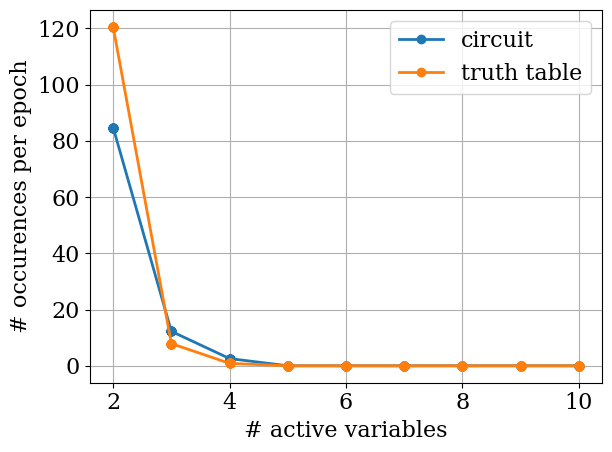

In [ ]:
for index, info in enumerate(['n_active_vars']):
    plt.figure()
    x = [k[index] for k in references.keys()]
    y = []
    y_circuit = []
    for info_val in x:
        tmp = []
        tmp_circuit = []
        for k in references.keys():
            if k[index]!=info_val: continue
            tmp.append(references[k]['seen'])
            tmp_circuit.append(references[k]['seen_circuit'])
        y.append(np.mean(tmp))
        y_circuit.append(np.mean(tmp_circuit))
    plt.plot(x, y_circuit, marker='o', label='circuit')
    plt.plot(x, y, marker='o', label='truth table')
    #plt.ylim(-1,15)
    plt.legend()
    if info=='n_active_vars':
        plt.xlabel('# active variables')
    plt.ylabel('# occurences per epoch')
    plt.tight_layout()
    #plt.savefig(savedir+'redundancy.pdf')
    plt.show()


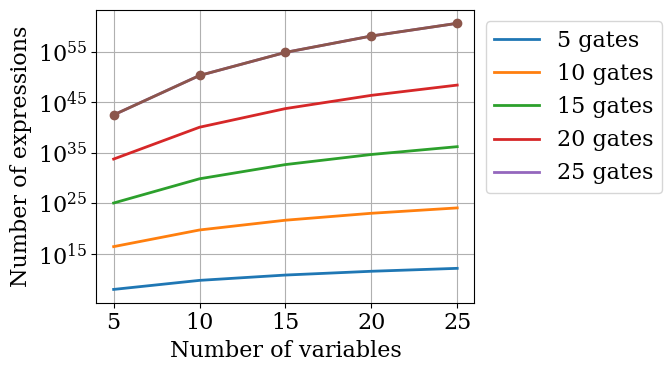

4.5947151466533086e+60


In [ ]:
def num_trees(L, p1, p2, n):
    if n==0: return L
    elif n==1: return p2*(L*L+1)/2 + p1*L
    else: return (1/(n+1)) * ((p1+2*L*p2)*(2*n-1)*num_trees(L, p1, p2, n-1) - p1*(n-2)*num_trees(L, p1, p2, n-2))

fig = plt.figure(figsize=(7,4))
nops = range(5,30,5)
dims = range(5,30,5)
for nop in nops:
    y = []
    for dimension in dims:
        y.append(num_trees(dimension, 0, 3, nop))
    plt.semilogy(dims, y, label=f"{nop} gates")
    
plt.semilogy(nops, y, marker='o', ls='-')
plt.legend(bbox_to_anchor=(1,1))
#plt.semilogy(nops, num_float)

#plt.axhline(y=3e5*16, color='grey',ls='--', label='One epoch')
plt.xlabel('Number of variables')
plt.ylabel('Number of expressions')
#plt.legend()
plt.tight_layout()
plt.savefig(savedir+'num_expressions.pdf')
plt.show()
print(sum(y))